In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import mip.utils as utils

## load in data

In [5]:
adata = sc.read_h5ad('/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/HT206B1-H1/level_4/spatial_features.h5ad')
adata

AnnData object with n_obs × n_vars = 221081 × 30
    obs: 'area', 'perimeter', 'bbox_row_min', 'bbox_col_min', 'bbox_row_max', 'bbox_col_max', 'centroid_row', 'centroid_col', 'eccentricity', 'DAPI intensity max', 'CD31 intensity max', 'E-cadherin intensity max', 'CD4 intensity max', 'CD20 intensity max', 'Ki67 intensity max', 'CD68 intensity max', 'Pan-CK intensity max', 'CD8 intensity max', 'Histone H3 Pho intensity max', 'CD163 intensity max', 'Podoplanin intensity max', 'CD3 intensity max', 'CD36 intensity max', 'HIF1a intensity max', 'GLUT1 intensity max', 'GATA3 intensity max', 'CD45RO intensity max', 'CD45RA intensity max', 'SMA intensity max', 'CK19 intensity max', 'MGP intensity max', 'Vimentin intensity max', 'Maspin intensity max', 'Foxp3 intensity max', 'MMP9 intensity max', 'HLA-DR intensity max', 'CK14 intensity max', 'CD11c intensity max', 'CD44 intensity max', 'DAPI intensity min', 'CD31 intensity min', 'E-cadherin intensity min', 'CD4 intensity min', 'CD20 intensity min

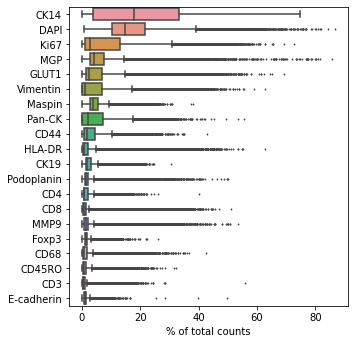

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [7]:
sc.pp.log1p(adata)

In [8]:
adata.var.index.to_list()

['DAPI',
 'CD31',
 'E-cadherin',
 'CD4',
 'CD20',
 'Ki67',
 'CD68',
 'Pan-CK',
 'CD8',
 'Histone H3 Pho',
 'CD163',
 'Podoplanin',
 'CD3',
 'CD36',
 'HIF1a',
 'GLUT1',
 'GATA3',
 'CD45RO',
 'CD45RA',
 'SMA',
 'CK19',
 'MGP',
 'Vimentin',
 'Maspin',
 'Foxp3',
 'MMP9',
 'HLA-DR',
 'CK14',
 'CD11c',
 'CD44']

In [9]:
adata.raw = adata

In [10]:
annotation_marker_map = {
    'Endothelial': ['CD31'],
    'Epithelial': ['E-cadherin', 'Pan-CK', 'CK14', 'CK19'],
    'B cell': ['CD20'],
    'Macrophage': ['CD68', 'CD163'],
    'DC': ['CD11c'],
    'T cell': ['CD3', 'CD4', 'CD8', 'Foxp3'],
    'Fibroblast/Myo': ['Podoplanin', 'SMA', 'Vimentin'],
    'Proliferating': ['Ki67']
}
annotation_markers = [v for k, vs in annotation_marker_map.items() for v in vs]

In [11]:
# I've found it helpful to limit to markers only used in annotation
# This helps keep the clusters cleaner
adata = adata[:, annotation_markers]
adata

View of AnnData object with n_obs × n_vars = 221081 × 17
    obs: 'area', 'perimeter', 'bbox_row_min', 'bbox_col_min', 'bbox_row_max', 'bbox_col_max', 'centroid_row', 'centroid_col', 'eccentricity', 'DAPI intensity max', 'CD31 intensity max', 'E-cadherin intensity max', 'CD4 intensity max', 'CD20 intensity max', 'Ki67 intensity max', 'CD68 intensity max', 'Pan-CK intensity max', 'CD8 intensity max', 'Histone H3 Pho intensity max', 'CD163 intensity max', 'Podoplanin intensity max', 'CD3 intensity max', 'CD36 intensity max', 'HIF1a intensity max', 'GLUT1 intensity max', 'GATA3 intensity max', 'CD45RO intensity max', 'CD45RA intensity max', 'SMA intensity max', 'CK19 intensity max', 'MGP intensity max', 'Vimentin intensity max', 'Maspin intensity max', 'Foxp3 intensity max', 'MMP9 intensity max', 'HLA-DR intensity max', 'CK14 intensity max', 'CD11c intensity max', 'CD44 intensity max', 'DAPI intensity min', 'CD31 intensity min', 'E-cadherin intensity min', 'CD4 intensity min', 'CD20 inten

In [12]:
sc.tl.pca(adata, svd_solver='arpack')

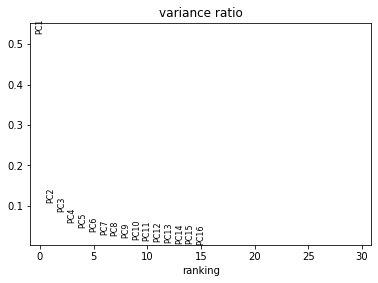

In [13]:
sc.pl.pca_variance_ratio(adata)

In [14]:
sc.pp.neighbors(adata, n_neighbors=15)

In [15]:
sc.tl.umap(adata)

In [16]:
sc.tl.leiden(adata, resolution=1.)

[autoreload of dask failed: Traceback (most recent call last):
  File "/diskmnt/Projects/Users/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/diskmnt/Projects/Users/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/diskmnt/Projects/Users/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/diskmnt/Projects/Users/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/diskmnt/P

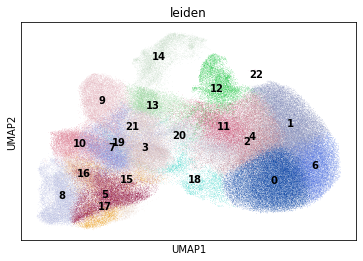

In [19]:
sc.pl.umap(adata, color=['leiden'], legend_loc='on data')

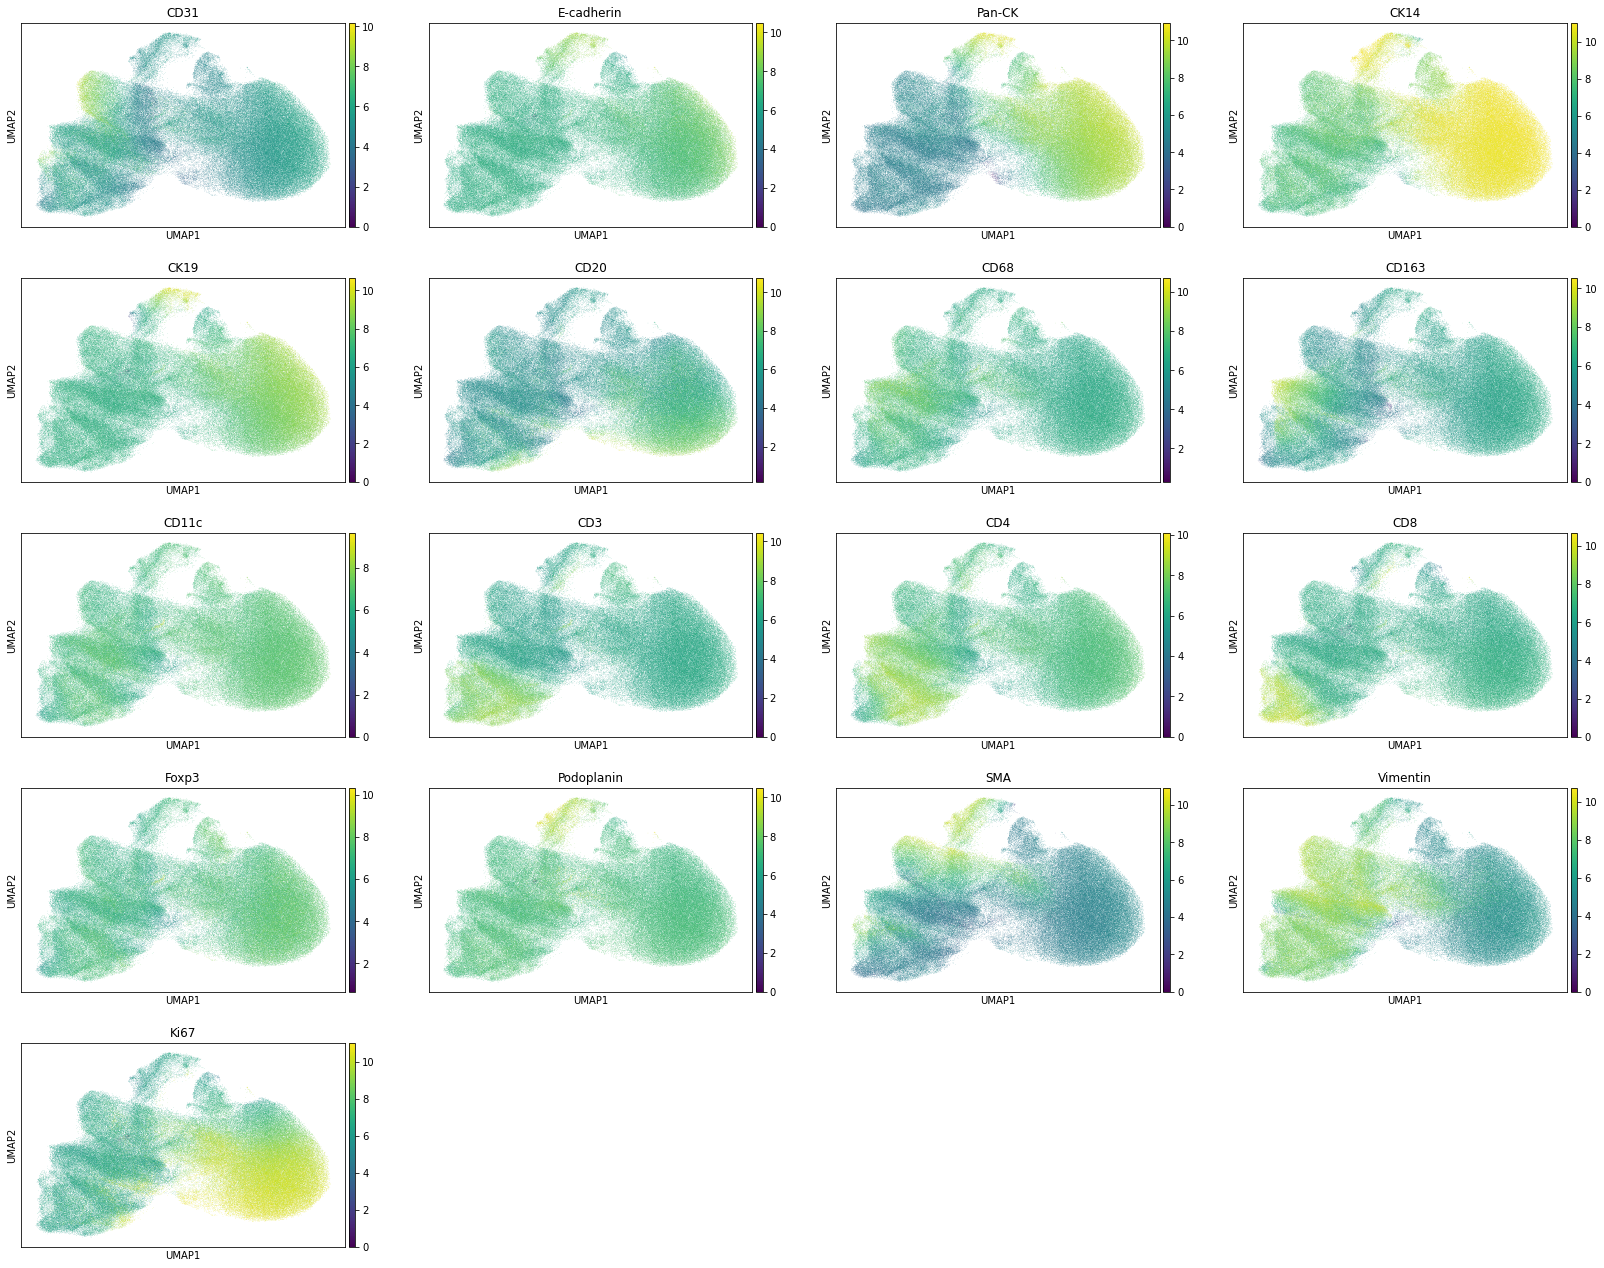

In [18]:
sc.pl.umap(adata, color=annotation_markers)

In [23]:
cluster_map = {
    'Endothelial': [9],
    'Myoepithelial': [14],
    'Malignant': [22, 1, 6, 0, 2, 4, 11, 18, 20, 12],
    'Macrophage': [10, 7],
    'DC': [19],
    'B cell': [17],
    'Fibroblast': [13, 21, 3],
    'CD8 T cell': [8],
    'CD4 T cell': [5, 16, 15],
}
r = {str(v):k for k, vs in cluster_map.items() for v in vs}
adata.obs['cell_type'] = [r.get(l, l)
                          for l in adata.obs['leiden']]

/diskmnt/Projects/Users/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


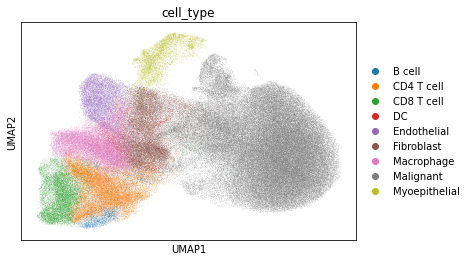

In [24]:
sc.pl.umap(adata, color='cell_type')

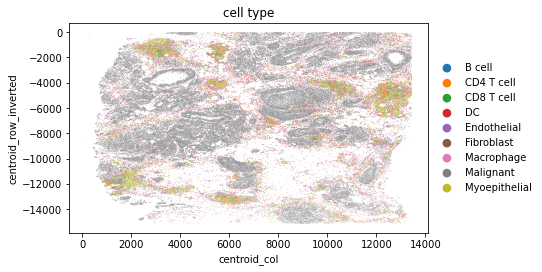

In [38]:
adata.obs['centroid_row_inverted'] = [-x for x in adata.obs['centroid_row']]
sc.pl.scatter(adata, x='centroid_col', y='centroid_row_inverted', color='cell_type')

In [39]:
adata.obs

,area,perimeter,bbox_row_min,bbox_col_min,bbox_row_max,bbox_col_max,centroid_row,centroid_col,eccentricity,DAPI intensity max,...,Foxp3 intensity min,MMP9 intensity min,HLA-DR intensity min,CK14 intensity min,CD11c intensity min,CD44 intensity min,leiden,cell type,cell_type,centroid_row_inverted
cell_id,,,,,,,,,,,,,,,,,,,,,
1,520,110.840620,0,3673,25,3709,8.378846,3693.750000,0.723583,49006.0,...,205.0,0.0,8.0,1547.0,404.0,38.0,6,Malignant,Malignant,-8.378846
2,409,98.704581,0,3711,26,3740,8.728606,3722.951100,0.452175,44971.0,...,15.0,0.0,8.0,4518.0,61.0,29.0,6,Malignant,Malignant,-8.728606
3,845,150.675144,0,3739,32,3776,13.584615,3755.928994,0.368285,49170.0,...,19.0,0.0,4.0,8671.0,21.0,71.0,6,Malignant,Malignant,-13.584615
4,241,70.870058,0,3873,12,3902,4.082988,3886.991701,0.928244,49978.0,...,191.0,47.0,6.0,56332.0,283.0,95.0,6,Malignant,Malignant,-4.082988
5,733,115.639610,0,3888,35,3921,16.049113,3906.064120,0.497079,59773.0,...,23.0,13.0,3.0,4903.0,65.0,66.0,6,Malignant,Malignant,-16.049113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221077,340,80.970563,15108,10235,15120,10268,15114.164706,10249.664706,0.935688,26368.0,...,108.0,0.0,149.0,1728.0,46.0,636.0,10,Macrophage,Macrophage,-15114.164706
221078,162,62.248737,15107,9158,15120,9182,15115.290123,9168.080247,0.861327,44711.0,...,1103.0,449.0,227.0,52670.0,445.0,910.0,1,Malignant,Malignant,-15115.290123
221079,35,24.485281,15116,9213,15120,9224,15117.828571,9218.000000,0.938642,33583.0,...,1359.0,1250.0,499.0,13957.0,810.0,507.0,0,Malignant,Malignant,-15117.828571


In [40]:
adata.write_h5ad('/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/HT206B1-H1/downstream_analysis/cell_annotation.h5ad')